# POGZ and Associated Syndrome


[White-Sutton syndrome](https://omim.org/entry/616364) is a neurodevelopmental disorder caused by pathogenic variants in the [POGZ](https://omim.org/entry/614787) gene.

<!-- Summarize key findings from previous studies on genotype-phenotype correlations in the syndrome. -->

One/Two/Several previous publications have reported candidate genotype-phenotype correlations in [Syndrome Name].

<!-- Cite specific studies and their findings. Replace with relevant studies and findings for the specific gene and syndrome. -->

[Negy et al. (2022)](https://pubmed.ncbi.nlm.nih.gov/35052493/) summarized data on 117 individuals with White-Sutton syndrome, including 12 novel individuals. They wrote:

> A severity scoring system was developed for the comparison. Mild and severe phenotypes were compared with the types and location of the variants and the predicted presence or absence of nonsense-mediated RNA decay (NMD). Missense variants were more often associated with mild phenotypes (p = 0.0421) and truncating variants predicted to escape NMD presented with more severe phenotypes (p < 0.0001). Within this group, variants in the prolin-rich region of the POGZ protein were associated with the most severe phenotypes (p = 0.0004).


## Imports 

In [2]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using genophenocorr version 0.8.0


# POGZ
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for POGZ.

In [3]:
gene_symbol = 'POGZ'
mane_tx_id = 'NM_015100.4'
mane_protein_id = "NP_055915.2"

In [ ]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets, load_phenopacket_folder

phenopacket_store_release = '0.1.22'  
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)

ppkt_d = "../../../phenopacket-store/notebooks/POGZ/phenopackets"
cohort, qc = load_phenopacket_folder(
   # phenopackets=phenopackets, 
   pp_directory=ppkt_d,
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals from {gene_symbol}')
qc.summarize()

Individuals Processed: 117individuals [00:02, 40.36individuals/s]
Loaded 117 individuals from Cohort(members=(Patient(labels:Patient 3[PMID_33277917_Patient_3], sex:Sex.FEMALE, age:Age(days=4017.75, timeline=Timeline.POSTNATAL), vital_status:VitalStatus(status=<Status.ALIVE: 1>, age_of_death=None), variants:(Variant(variant_info=VariantInfo(variant_coordinates=VariantCoordinates(region=GenomicRegion(contig=1, start=151423553, end=151423554, strand=+), ref=G, alt=C, change_length=0), sv_info=None), tx_annotations=(TranscriptAnnotation(gene_id:POGZ,transcript_id:NM_001194937.2,hgvs_cdna:NM_001194937.2:c.1497-3C>G,is_preferred:False,variant_effects:(<VariantEffect.SPLICE_REGION_VARIANT: 'SO:0001630'>, <VariantEffect.SPLICE_POLYPYRIMIDINE_TRACT_VARIANT: 'SO:0002169'>, <VariantEffect.INTRON_VARIANT: 'SO:0001627'>),overlapping_exons:None,protein_id:NP_001181866.1,hgvsp:None,protein_effect_location:None), TranscriptAnnotation(gene_id:POGZ,transcript_id:NM_001194938.2,hgvs_cdna:NM_001194938.2:

## Define Configuration & Run Analysis

In [5]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
97,Delayed speech and language development
85,Global developmental delay
84,Intellectual disability
80,Delayed gross motor development
49,Microcephaly
48,Autistic behavior
33,Feeding difficulties
26,Reduced social responsiveness
25,Hypertelorism
23,Midface retrusion


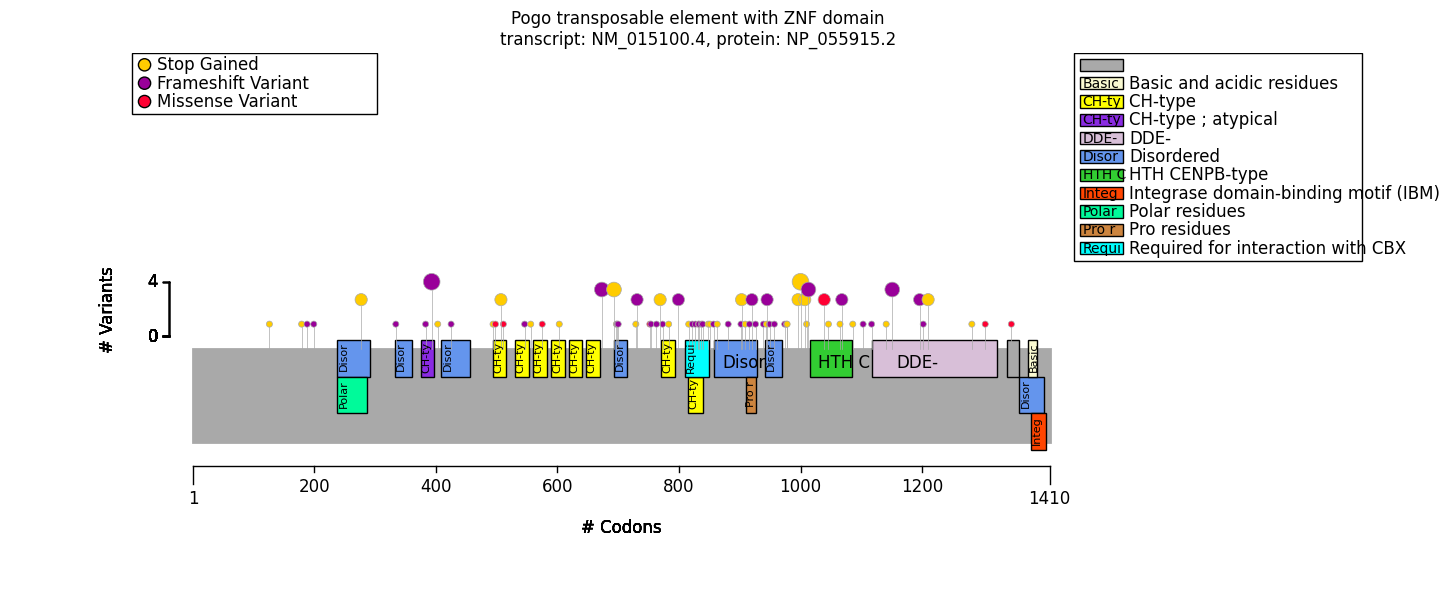

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService, configure_default_protein_metadata_service
import matplotlib.pyplot as plt
from gpsea.view import ProteinVisualizer

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id) 
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

pogz_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
pogz_fig.tight_layout()

In [7]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
2,Disordered,Region,239 - 291,p.Ser278Ter
2,Polar residues,Compositional bias,239 - 286,p.Ser278Ter
1,Disordered,Region,333 - 361,p.Pro336GlnfsTer23
5,C2H2-type 1; atypical,Zinc finger,376 - 397,p.Arg385SerfsTer4; p.Met394ValfsTer9
1,Disordered,Region,410 - 456,p.Glu427Ter
5,C2H2-type 2,Zinc finger,495 - 516,p.Arg495Ter; p.Arg508Ter; p.Cys499Phe; p.His512Asn
1,C2H2-type 3,Zinc finger,531 - 553,p.Cys547Ter
1,C2H2-type 4,Zinc finger,561 - 583,p.Leu576Pro
1,C2H2-type 5,Zinc finger,591 - 613,p.Glu604Ter
0,C2H2-type 6,Zinc finger,620 - 641,


In [8]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
4,1_151406034_151406034_G_A,c.3001C>T (p.Arg1001Ter),19,stop gained
4,1_151424958_151424960_CAT_C,c.1180_1181del (p.Met394ValfsTer9),8,frameshift
3,1_151405577_151405579_CCT_C,c.3456_3457del (p.Glu1154ThrfsTer4),19,frameshift
3,1_151408734_151408735_CG_C,c.2020del (p.Arg674ValfsTer9),13,frameshift
3,SO:1000029_HGNC:18801_POGZ,SV involving POGZ (p.?),,chromosomal deletion
3,1_151408563_151408563_G_A,c.2080C>T (p.Arg694Ter),14,stop gained
2,1_151405442_151405444_CCA_C,c.3591_3592del (p.Ser1197ArgfsTer4),19,frameshift
2,1_151423950_151423950_G_A,c.1522C>T (p.Arg508Ter),9,"stop gained, splice region"
2,1_151405827_151405829_CAT_C,c.3206_3207del (p.Tyr1069Ter),19,frameshift
2,1_151406909_151406910_AC_A,c.2545+1del (-),-,splice donor


## Genotype-Phenotype Correlation (GPC) Analysis

In [9]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [12]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_predicate = monoallelic_predicate(
    a_predicate=missense,
    b_predicate=~missense
)
missense_result =  analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo, missense_result)


Allele group                                            A                B  \
                                                    Count Percent    Count   
Global developmental delay [HP:0001263]               7/8     88%    78/78   
Delayed speech and language development [HP:000...    8/9     89%    89/92   
Delayed gross motor development [HP:0002194]          6/7     86%    74/80   
Autistic behavior [HP:0000729]                        4/4    100%    44/59   
Microcephaly [HP:0000252]                             1/3     33%    48/86   
Decreased head circumference [HP:0040195]             1/1    100%    48/48   
Abnormal axial skeleton morphology [HP:0009121]       5/5    100%    62/62   
Aplasia/Hypoplasia of the cerebrum [HP:0007364]       1/1    100%    49/49   
Aplasia/Hypoplasia involving the central nervou...    3/3    100%    55/55   
Morphological central nervous system abnormalit...    3/3    100%    57/57   
Abnormal cerebral morphology [HP:0002060]             2/2    100%    50/50   
Abnormal brain morphology [HP:0012443]                3/3    100%    56/56   
Motor delay [HP:0001270]                              8/8    100%    76/76   
Neurodevelopmental delay [HP:0012758]                 9/9    100%  103/103   
Neurodevelopmental abnormality [HP:0012759]         10/10    100%  105/105   
Language impairment [HP:0002463]                      8/8    100%    89/89   
Abnormal communication [HP:0034434]                   8/8    100%    89/89   
Abnormal speech pattern [HP:0002167]                  8/8    100%    89/89   
Intellectual disability [HP:0001249]                  8/8    100%    76/79   
Diagnostic behavioral phenotype [HP:0025783]          4/4    100%    44/44   
Atypical behavior [HP:0000708]                        6/6    100%    62/62   
Feeding difficulties [HP:0011968]                     2/2    100%    31/46   
Seizure [HP:0001250]                                  2/5     40%    19/47   

Allele group                                                                   \
                                                   Percent Corrected p values   
Global developmental delay [HP:0001263]               100%                1.0   
Delayed speech and language development [HP:000...     97%                1.0   
Delayed gross motor development [HP:0002194]           92%                1.0   
Autistic behavior [HP:0000729]                         75%                1.0   
Microcephaly [HP:0000252]                              56%                1.0   
Decreased head circumference [HP:0040195]             100%                1.0   
Abnormal axial skeleton morphology [HP:0009121]       100%                1.0   
Aplasia/Hypoplasia of the cerebrum [HP:0007364]       100%                1.0   
Aplasia/Hypoplasia involving the central nervou...    100%                1.0   
Morphological central nervous system abnormalit...    100%                1.0   
Abnormal cerebral morphology [HP:0002060]             100%                1.0   
Abnormal brain morphology [HP:0012443]                100%                1.0   
Motor delay [HP:0001270]                              100%                1.0   
Neurodevelopmental delay [HP:0012758]                 100%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Language impairment [HP:0002463]                      100%                1.0   
Abnormal communication [HP:0034434]                   100%                1.0   
Abnormal speech pattern [HP:0002167]                  100%                1.0   
Intellectual disability [HP:0001249]                   96%                1.0   
Diagnostic behavioral phenotype [HP:0025783]          100%                1.0   
Atypical behavior [HP:0000708]                        100%                1.0   
Feeding difficulties [HP:0011968]                      67%                1.0   
Seizure [HP:0001250]                                   40%                1.0   

Allele group           

In [4]:
from gpsea.analysis.pscore import PhenotypeScorer

ImportError: cannot import name 'VariantPredicate' from 'gpsea.analysis.predicate' (/Users/robin/GIT/gpsea-cs/venv/lib/python3.12/site-packages/gpsea/analysis/predicate/__init__.py)

In [ ]:
# TODO: Check compare_by_variant_key parameters and/or variables
feature = analysis.compare_by_variant_key(variant_key="12_114401830_114401830_C_T")
feature.summarize(hpo, PatientCategories.YES)